Processing EIS patches
---

A notebook to
- Read in raw FIP maps in their individual patches
- Re-project each patch
- Save the resulting synoptic map

In [3]:
from pathlib import Path
import warnings

import numpy as np
import scipy.io

from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u
from astropy.wcs import WCS

import sunpy.map
from sunpy.util.exceptions import SunpyWarning

from reproject import reproject_interp, reproject_exact
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolor

Construct output WCS
---

In [4]:
shape_out = [720, 1440]
def make_out_header(obstime):
    out_header = sunpy.map.make_fitswcs_header(np.empty(shape_out),
                                           SkyCoord(0, 0, unit=u.deg,
                                                    frame="heliographic_carrington",
                                                    obstime=obstime),
                                           scale=[180 / shape_out[0],
                                                  360 / shape_out[1]] * u.deg / u.pix,
                                           projection_code="CAR")
    return out_header

make_out_header(Time.now())

MetaDict([('wcsaxes', 2),
          ('crpix1', 720.5),
          ('crpix2', 360.5),
          ('cdelt1', 0.25),
          ('cdelt2', 0.25),
          ('cunit1', 'deg'),
          ('cunit2', 'deg'),
          ('ctype1', 'CRLN-CAR'),
          ('ctype2', 'CRLT-CAR'),
          ('crval1', 0.0),
          ('crval2', 0.0),
          ('lonpole', 0.0),
          ('latpole', 90.0),
          ('dateref', '1858-11-17'),
          ('mjdrefi', 0.0),
          ('mjdreff', 0.0),
          ('date-obs', '2020-04-24T15:50:15.582')])

Read in raw EIS observations
---
These are used to get the WCS for the individual FIP maps.

In [5]:
from eispy.cube import read

eis_dir = Path('/Users/dstansby/Data/hinode/eis')
inmaps = []
for fname in tqdm(eis_dir.glob('*.fits'), total=26):
    # print(fname)
    observation = read(fname)
    fexiii = observation['FE XII 195.120']
    # Fix a crval - see http://solarb.mssl.ucl.ac.uk/SolarB/DEV/eis_gifs/2013/01/16/eis_l0_20130116_213443.fits/eis_l0_20130116_213443.fits_line_00_FE_X_184.530.int.gif
    # for the correct alignment
    if observation.obs_starttime == Time('2013-01-16 21:34:43'):
        fexiii.wcs.wcs.crval[0] = (-700 * u.arcsec).to(u.deg).value
        fexiii.wcs.wcs.crval[1] = (-57.281553398058236 * u.arcsec).to(u.deg).value
    # Fix another crval - see http://solarb.mssl.ucl.ac.uk/SolarB/DEV/eis_gifs/2013/01/16/eis_l0_20130116_230943.fits/eis_l0_20130116_230943.fits_line_00_FE_X_184.530.int.gif
    # for the correct alignment
    elif observation.obs_starttime == Time('2013-01-16 23:09:43'):
        fexiii.wcs.wcs.crval[0] = (-700 * u.arcsec).to(u.deg).value
        fexiii.wcs.wcs.crval[1] = (-528.306155151286 * u.arcsec).to(u.deg).value
    inmaps.append(fexiii)
    del observation

Set MJD-OBS to 56308.764387 from DATE-OBS'. [astropy.wcs.wcs]
Set MJD-OBS to 56310.182789 from DATE-OBS'. [astropy.wcs.wcs]
Set MJD-OBS to 56309.722731 from DATE-OBS'. [astropy.wcs.wcs]
Set MJD-OBS to 56309.089734 from DATE-OBS'. [astropy.wcs.wcs]
Set MJD-OBS to 56308.501539 from DATE-OBS'. [astropy.wcs.wcs]
Set MJD-OBS to 56308.899109 from DATE-OBS'. [astropy.wcs.wcs]
Set MJD-OBS to 56308.965081 from DATE-OBS'. [astropy.wcs.wcs]
Set MJD-OBS to 56309.924120 from DATE-OBS'. [astropy.wcs.wcs]
Set MJD-OBS to 56308.831748 from DATE-OBS'. [astropy.wcs.wcs]
Set MJD-OBS to 56308.697373 from DATE-OBS'. [astropy.wcs.wcs]
Set MJD-OBS to 56310.250509 from DATE-OBS'. [astropy.wcs.wcs]
Set MJD-OBS to 56309.560579 from DATE-OBS'. [astropy.wcs.wcs]
Set MJD-OBS to 56308.400926 from DATE-OBS'. [astropy.wcs.wcs]
Set MJD-OBS to 56309.457801 from DATE-OBS'. [astropy.wcs.wcs]
Set MJD-OBS to 56309.157095 from DATE-OBS'. [astropy.wcs.wcs]
Set MJD-OBS to 56308.550845 from DATE-OBS'. [astropy.wcs.wcs]
Set MJD-

Read in FIP maps
---

In [6]:
fip_dir = Path('/Users/dstansby/Data/hinode/fip_maps')
# This can also include 'logn', but leave out to save memory
fip_maps = {var: [] for var in ['fip_bias']}
fname_time_fmt = '%Y%m%d_%H%M'

# Loop through the FIP map .sav files
for fname in tqdm(fip_dir.glob('*.sav'), total=26):
    # Read in file
    fip_map = scipy.io.readsav(fname)
    date_obs = Time.strptime(fname.stem[-13:], fname_time_fmt)
    # Loop through variables stored in FIP file
    for key in ['fip_bias']:
        data = fip_map[key][:, ::-1].copy()
        # Loop through EIS maps to find one that matches the date
        for i, eism in enumerate(inmaps):
            if (Time(eism.meta['DATE-OBS']).strftime(fname_time_fmt) ==
                    date_obs.strftime(fname_time_fmt)):
                wcs = eism.wcs.dropaxis(2)
                break
                
        if key == 'fip_bias':
            # Remove top 16 lines from each fip map, which seem to be bad pixels
            data[-16:, :] = np.nan
        m = sunpy.map.Map(data, wcs)
        fip_maps[key].append(m)
        
fip_maps['intensity'] = []
for inmap in inmaps:
    intensity = inmap.total_intensity
    fip_maps['intensity'].append(sunpy.map.Map(intensity.data, intensity.wcs))

Replace the intensity data with calibrated L1 data
---

In [7]:
calibrated_dir = Path('/Users/dstansby/Data/hinode/eis/l1')
fname_time_fmt = '%Y%m%d_%H%M'

for fname in tqdm(calibrated_dir.glob('*.sav'), total=26):
    # Read in file
    l1_file = scipy.io.readsav(fname)
    date_obs = Time.strptime(fname.stem[:-11], fname_time_fmt)
    for i in range(len(fip_maps['intensity'])):
        m = fip_maps['intensity'][i]
        if (m.date.strftime(fname_time_fmt) == date_obs.strftime(fname_time_fmt)):
            data = l1_file['fexii_imap'][0][0][:, ::-1].copy()
            assert data.shape == m.data.shape
            header = m.meta
            fip_maps['intensity'][i] = sunpy.map.Map(data, header)

In [8]:
def reproject(data, wcs, date_obs):
    """
    Re-project some data on to a Carrington map.
    
    Parameters
    ----------
    data : ndarray
        Data to be reprojected.
    wcs : wcs
        WCS of data.
    date_obs :
        Observation date.
    
    Returns
    -------
    sunpy.map.Map
        Reprojected map.
    """
    out_header = make_out_header(date_obs)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        array = reproject_interp((data, wcs),
                                 WCS(out_header),
                                 shape_out=shape_out,
                                 return_footprint = False)
        return sunpy.map.Map((array, out_header))

def make_master_map(maps):
    """
    Given a series of maps with the same shape and WCS, add them together to
    make one complete map.
    
    Parameters
    ----------
    maps : list of GenericMap
    
    Returns
    -------
    GenericMap
    """
    # This contains data averaged over all the different patches
    master_data = maps[0].data
    for m in maps:
        master_data = np.nanmean(np.array([master_data, m.data]), axis=0)

    master_map = sunpy.map.Map(master_data, maps[0].wcs)
    return master_map

Reproject each individual fip map
---

In [9]:
def reproject_maps(key):
    warnings.simplefilter('ignore', SunpyWarning)
    warnings.simplefilter('ignore')
    np.seterr(invalid='ignore')
    print(f'Processing {key}...')
    
    outmaps = []
    for map_in in tqdm(fip_maps[key]):
        # Extract WCS and data
        wcs = map_in.wcs
        data = map_in.data
        date_obs = map_in.meta['DATE-OBS']

        # Get rid of < 0 data for data that should be > 0 by definition
        data[data <= 0] = np.nan
        # Get rid of ridiculous FIP bias values
        if key in ['fip_bias']:
            data[data > 10] = np.nan

        # Do the reprojection
        outmaps.append(reproject(data, wcs, date_obs))
            
    warnings.simplefilter('default', SunpyWarning)
    warnings.simplefilter('default')
    return outmaps

In [10]:
reprojected_maps = {key: reproject_maps(key) for key in ['intensity', ]}

Processing intensity...


Put all of these maps together to make one master map

In [11]:
master_maps = {key: make_master_map(reprojected_maps[key]) for key in reprojected_maps}

<ipython-input-8-0a9a97cb24b9>:45: RuntimeWarning: Mean of empty slice
  master_data = np.nanmean(np.array([master_data, m.data]), axis=0)


[0.56502166 3.45412388]


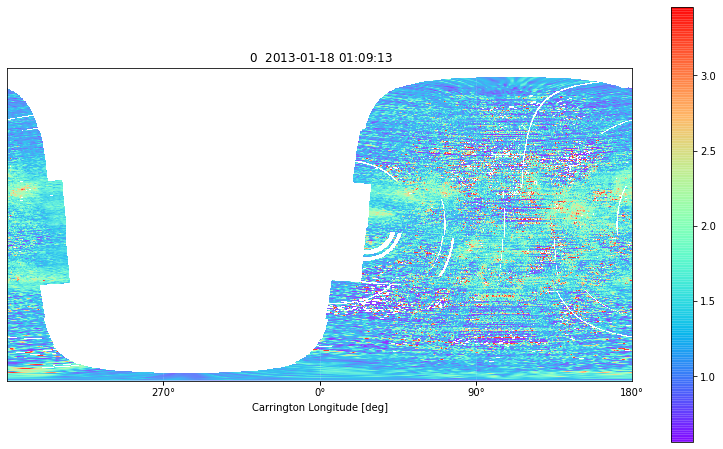

In [16]:
fip_map = master_maps['fip_bias']

fig = plt.figure(figsize=(14, 8))
ax = plt.subplot(projection=fip_map)
fip_map.plot_settings['cmap'] = 'rainbow'
vlims = np.nanpercentile(fip_map.data, [1, 99])
print(vlims)
fip_map.plot_settings['norm'] = mcolor.Normalize(vmin=vlims[0], vmax=vlims[1])
fip_map.plot(ax, alpha=0.8)
plt.colorbar()
# fig.savefig('figs/logn.pdf', bbox_inches='tight')

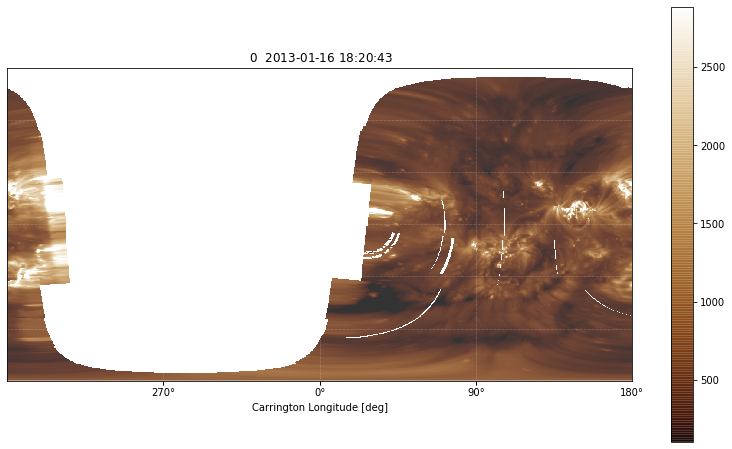

In [12]:
intensity_map = master_maps['intensity']

fig = plt.figure(figsize=(14, 8))
ax = plt.subplot(projection=intensity_map)
intensity_map.plot_settings['cmap'] = 'sdoaia193'
vlims = np.nanpercentile(intensity_map.data, [1, 99])
intensity_map.plot_settings['norm'] = mcolor.Normalize(vmin=vlims[0], vmax=vlims[1])
intensity_map.plot(ax, alpha=0.8)
plt.colorbar()

In [13]:
for key in master_maps:
    master_maps[key].save(f'maps/carrington_{key}.fits', overwrite=True)